In [88]:
from torchvision import transforms, datasets
import torch as torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import os

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [90]:
torch.cuda.device_count()

6

In [91]:
# params
image_size = 64
bs=128
std,mean = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5) #normalization of image
real_label=1
fake_label=0
lr=0.0002
beta=0.5
nz=100

In [92]:
compose = transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize(std, mean),
                              ])

In [93]:
#dataset = datasets.ImageFolder(root=os.path.join(os.getcwd(), 'cats/'), transform=compose)
dataset = datasets.ImageFolder(root=os.path.join(os.getcwd(), 'celeba/'), transform=compose)

In [94]:
#cifar = datasets.CIFAR10(root='cifar10', download=True, train=True, transform=compose)
#dataset = [ds for ds in tqdm(cifar) if ds[1] == 5]

In [95]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True,num_workers=6)

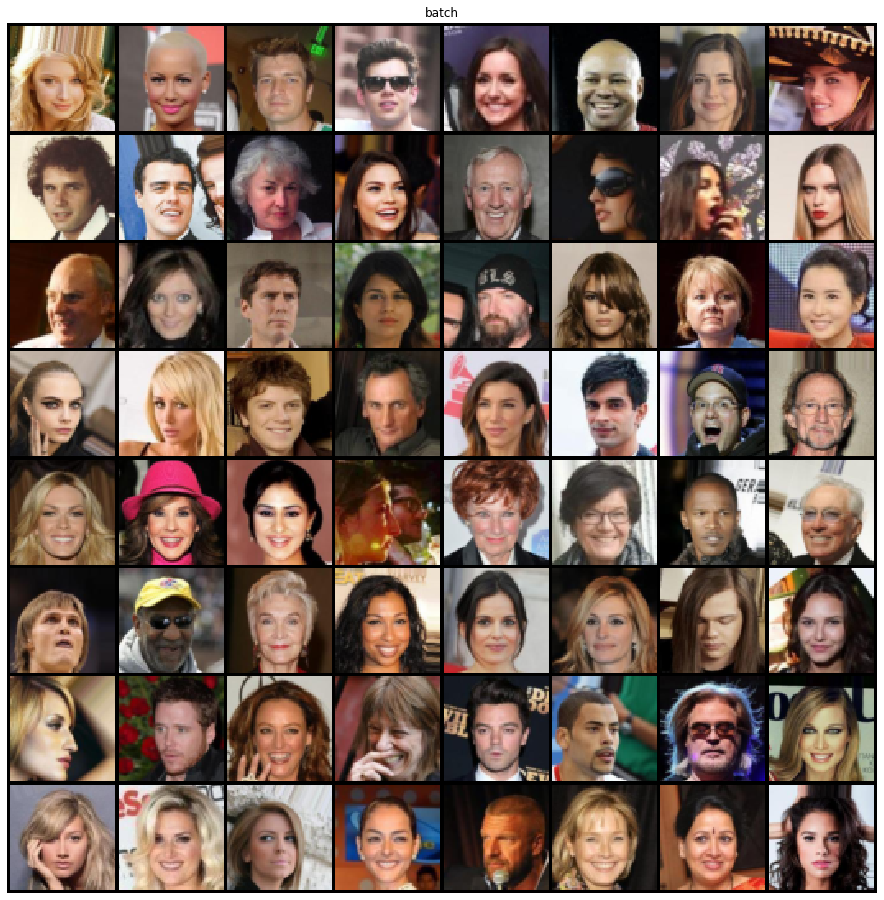

In [96]:
batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("batch")
plt.imshow(vutils.make_grid(batch[0][:64], padding=2, normalize=True).cpu().permute(1,2,0))

In [97]:
def imshow(img, std=std, mean=mean):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.imshow(img)

202599

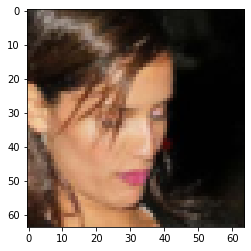

In [98]:
imshow(dataset[3][0],std,mean)
len(dataset)

In [99]:
def weights_init(m):
    module_name = m.__class__.__name__
    if 'Conv' in module_name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in module_name:
      #https://discuss.pytorch.org/t/weight-initialization-for-batchnorm-in-dcgan-tutorial/32351
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [100]:
def printShapes(model, input):
    a = input
    print(a.shape)
    for l in model.layers:
        if 'Conv' in l.__class__.__name__:
            a = l(a)
            print(a.shape)

In [101]:
def convT_bn(in_channels,
             out_channels,
             kernel_size,
             stride, padding, 
             bias=False, 
             act=nn.ReLU(True)):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
    layers.append(act)
    layers.append(nn.BatchNorm2d(out_channels)) #TODO YONIGO - test bn before or after relu
    return layers

#from ConvTranspose2d doc:
#Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
#p=((Hin-1)*s+k-Hout)/2
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
          *convT_bn(nz,1024,4,1,0), #p=((1-1)*2+4-4)/2 => p=0
          *convT_bn(1024, 512,4,2,1),
          *convT_bn(512,256,4,2,1),
          *convT_bn(256,128,4,2,1),
          nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
          nn.Tanh()
        )
    def forward(self, input):
        return self.layers(input)
        
g = Generator()

noise = torch.randn(bs, nz, 1, 1)
printShapes(g,noise)   

torch.Size([128, 100, 1, 1])
torch.Size([128, 1024, 4, 4])
torch.Size([128, 512, 8, 8])
torch.Size([128, 256, 16, 16])
torch.Size([128, 128, 32, 32])
torch.Size([128, 3, 64, 64])


In [102]:
def conv_bn(in_channels,
            out_channels,
            kernel_size,
            stride, padding, 
            bias=False, 
            act=nn.LeakyReLU(0.2,True)):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
    layers.append(act)
    layers.append(nn.BatchNorm2d(out_channels))
    return layers


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
          #nn.Conv2d(3, 64*2, 4, 2, 1, bias=False),
          #nn.LeakyReLU(0.2,True),
          *conv_bn(3,128,4,2,1),
          *conv_bn(128,256,4,2,1),
          *conv_bn(256,512,4,2,1), 
          *conv_bn(512,1024,4,2,1),
          nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            #sigmoid in BCEWithLogitsLoss
        )
    def forward(self, input):
        return self.layers(input)


d = Discriminator()
abatch = next(iter(dataloader))
printShapes(d,abatch[0])

torch.Size([128, 3, 64, 64])
torch.Size([128, 128, 32, 32])
torch.Size([128, 256, 16, 16])
torch.Size([128, 512, 8, 8])
torch.Size([128, 1024, 4, 4])
torch.Size([128, 1, 1, 1])


In [103]:
def fit(epochs, iterator, optimizer_g, optimizer_d,discriminator,generator):
    criterion = nn.BCEWithLogitsLoss()
    i=0
    generator.train()
    discriminator.train()
    static_noise = torch.randn(16, nz, 1, 1, device=device)
    for epoch in tqdm(range(epochs)):
        for j,batch in enumerate(tqdm(iterator, leave=False)):
            bs=batch[1].shape[0]
            # Train disciminator
            # Train with real samples
            optimizer_d.zero_grad()
            y=torch.full_like(batch[1], real_label, device=device).float()#real_label
#            y=torch.rand(bs,device=device).float()*0.1+0.9 # smoothing 0.9-1
            yhat=discriminator(batch[0].to(device)).view(-1)
            loss_real=criterion(yhat,y)
            loss_real.backward()
            Dx = yhat.sigmoid().mean().item()
            # Train with fake samples
            noise = torch.randn(bs, nz, 1, 1, device=device)
            fake_images = generator(noise)
            y=torch.full_like(batch[1], fake_label,device=device).float() #fake_label
#            y=torch.rand(bs,device=device).float()*0.1 # smoothing 0-0.1
            yhat=discriminator(fake_images.detach()).view(-1)
            loss_fake=criterion(yhat,y)
            loss_fake.backward()

            optimizer_d.step()
            loss_d = loss_real + loss_fake
            DGz = yhat.sigmoid().mean().item()

            # Train generator
            optimizer_g.zero_grad()
            y=torch.full_like(batch[1], real_label, device=device).float() #generator must create real images
            yhat=discriminator(fake_images).view(-1)
            loss_g = criterion(yhat,y)
            loss_g.backward()
            optimizer_g.step()
            writer.add_scalars('losses', {'loss_d':loss_d.item(),
                                          'loss_g':loss_g.item()}, i)
 
            writer.add_scalars('output', {'D(x)':Dx,
                                          'D(G(z))':DGz}, i)
    
            if (i%500 == 0) or ((epoch == epochs-1) and j == (len(iterator)-1)):
                with torch.no_grad():
                    fake_images = generator(static_noise)
                grid = torchvision.utils.make_grid(fake_images, normalize=True,nrow=4)
                writer.add_image('images', grid, i)
                
            i+=1

In [104]:
generator = nn.DataParallel(Generator()).to(device)
generator.apply(weights_init)
discriminator = nn.DataParallel(Discriminator()).to(device)
discriminator.apply(weights_init)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta, 0.999))

In [105]:
writer = SummaryWriter('mylogs/baseline_5epochs/',flush_secs=1)
fit(5, dataloader, optimizer_g, optimizer_d, discriminator, generator)

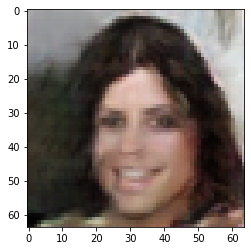

In [106]:
generator.eval()
with torch.no_grad():
    noise = torch.randn(1, nz, 1, 1, device=device)
    fake_images = generator(noise)
imshow(fake_images[0],std,mean)

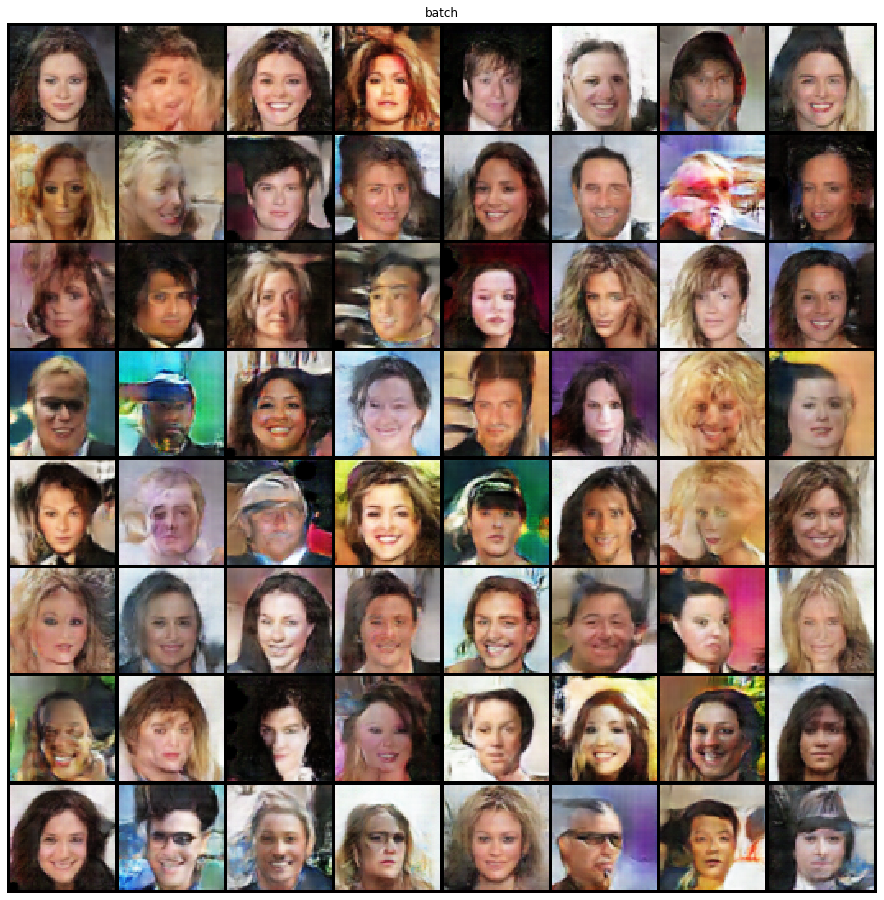

In [107]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("batch")
generator.eval()
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = generator(noise)
#plt.imshow(vutils.make_grid(batch[0][:64], padding=2, normalize=True).cpu().permute(1,2,0))
grid=torchvision.utils.make_grid(fake_images,normalize=True,nrow=8)
plt.imshow(grid.cpu().permute(1,2,0))

In [65]:
z = noise[36].unsqueeze(0)

generator.eval()
with torch.no_grad():
    imshow(generator())

RuntimeError: number of dims don't match in permute

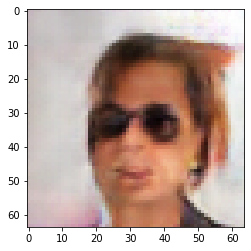

In [83]:
with torch.no_grad():
    imshow(generator(z)[0])

In [55]:
pics_with_glasses=[]

In [57]:
pics_with_glasses.append((fake_images[36],noise[36]))